# COSC 551 Assignment 2: Time-Series
*By Ben Murarotto*
### Introduction
In this assignment I used the Electricity Production Dataset available on Kaggle to train and compare LSTM and GRU networks on data from TEN different countries, ensuring that you select countries from various geolocations, populations, economic statuses and environmental conditions. 
I then apply had to apply trained models to data from FIVE different countries (unseen, out of sample) to evaluate its effectiveness in answering the following research question:

**Are RNNs useful in predicting the amount of electricity (in GWh) of a specific type (e.g., Wind, Solar, Natural Gas, etc.) produced by a country?**

To start this project lets import our dataset and do some exploratory work.
We want to check which unique countries are present and then decide on which 10 we want to use in our train set.

In [34]:
import os
import pandas as pd
from glob import glob

## os.chdir("C:\\Users\\demol\\University1\\MDSC\\COSC551\\Time_Series")
root_dir = os.getcwd()
file_path = glob(os.path.join(root_dir, "*.csv"))


dataframe = pd.read_csv(file_path[0])
dataframe.head(10)

,country_name,date,parameter,product,value,unit
0,Australia,12/1/2023,Net Electricity Production,Electricity,22646.1901,GWh
1,Australia,12/1/2023,Net Electricity Production,Total Combustible Fuels,13397.9356,GWh
2,Australia,12/1/2023,Net Electricity Production,"Coal, Peat and Manufactured Gases",9768.5223,GWh
3,Australia,12/1/2023,Net Electricity Production,Oil and Petroleum Products,289.5415,GWh
4,Australia,12/1/2023,Net Electricity Production,Natural Gas,3091.9272,GWh
5,Australia,12/1/2023,Net Electricity Production,Combustible Renewables,247.9446,GWh
6,Australia,12/1/2023,Net Electricity Production,Hydro,1047.8540,GWh
7,Australia,12/1/2023,Net Electricity Production,Wind,2719.2534,GWh
8,Australia,12/1/2023,Net Electricity Production,Solar,5481.1471,GWh
9,Australia,12/1/2023,Net Electricity Production,"Total Renewables (Hydro, Geo, Solar, Wind, Other)",9496.1991,GWh


We need to take a closer look at our range of classes for parameter and product to better answer the problem.

In [35]:
pd.Series(dataframe["parameter"].unique())

0        Net Electricity Production
1           Used for pumped storage
2               Distribution Losses
3    Final Consumption (Calculated)
4                     Total Imports
5                     Total Exports
6                           Remarks
dtype: object

In [36]:
pd.Series(dataframe["product"].unique())

0                                           Electricity
1                               Total Combustible Fuels
2                     Coal, Peat and Manufactured Gases
3                            Oil and Petroleum Products
4                                           Natural Gas
5                                Combustible Renewables
6                                                 Hydro
7                                                  Wind
8                                                 Solar
9     Total Renewables (Hydro, Geo, Solar, Wind, Other)
10                     Other Combustible Non-Renewables
11                                           Geothermal
12                                        Not Specified
13                                              Nuclear
14                     Data is estimated for this month
15                                     Other Renewables
dtype: object

Since we are looking at the amount of energy produced (GWh) our key parameter of interest will be Net Electricity Production, where all others appear to be not relevant. Let's take a strong profile of energy sources of both renewable and non renewable form to act as the features for our model.
In this instance I chose Natural Gas, Hydro, Wind, Solar, Geothermal and Nuclear.

In [37]:
selected_parameter = "Net Electricity Production"
selected_products = ["Natural Gas", "Hydro", "Wind", "Solar", "Geothermal", "Nuclear"]

Let's choose countries across each available continent - 
Japan and India from Asia
Brazil and Colombia from South America
United States and Mexico from North America
Turkey, Denmark, France and the UK from Europe

We are going to filter the dataframe for electricity and then make a subset for each country.

In [ ]:
##Code written with the assitance of ChatGPT to filter the dataframe based on the selected parameter and products

train_countries = ["Japan", "India", "Brazil", "Colombia", "United States", "Mexico", "Turkey", "Norway", "France", "Slovenia"]
test_countries = ["Australia", "Italy", "Lithuania", "Korea", "Chile"]

filtered_df = dataframe[
    (dataframe["parameter"] == selected_parameter) &
    (dataframe["product"].isin(selected_products))
].copy()
filtered_df = filtered_df.drop("unit", axis=1, errors="ignore")
filtered_df.head(2)


,country_name,date,parameter,product,value
4,Australia,12/1/2023,Net Electricity Production,Natural Gas,3091.9272
6,Australia,12/1/2023,Net Electricity Production,Hydro,1047.8540


In [39]:
filtered_df["date"] = pd.to_datetime(filtered_df["date"])

In [ ]:
import matplotlib.pyplot as plt

## Function written with the assitance of ChatGPT to plot the data for a single country and product.

def plot_country_data(df, countries, target_product):
    """
    Plots electricity production (in GWh) over time for multiple selected countries
    for a single selected product directly from the long-format (filtered) dataframe.

    Args:
        df (pd.DataFrame): The long-format dataframe containing 'country_name', 'date', 'product', and 'value'.
        countries (list): A list of country names to plot.
        target_product (str): The name of the energy product (e.g., 'Natural Gas') to plot.

    The function generates one plot with separate lines for each selected country.
    """

    plt.figure(figsize=(12, 6))

    for country in countries:
        country_data = df[
            (df["country_name"] == country) &
            (df["product"] == target_product)
        ].sort_values("date")
        plt.plot(country_data["date"], country_data["value"], label=country, marker="o")


    plt.title(f"{target_product} Production Over Time (Multiple Countries)")
    plt.xlabel("Date")
    plt.ylabel("GWh")
    plt.legend(title="Country")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


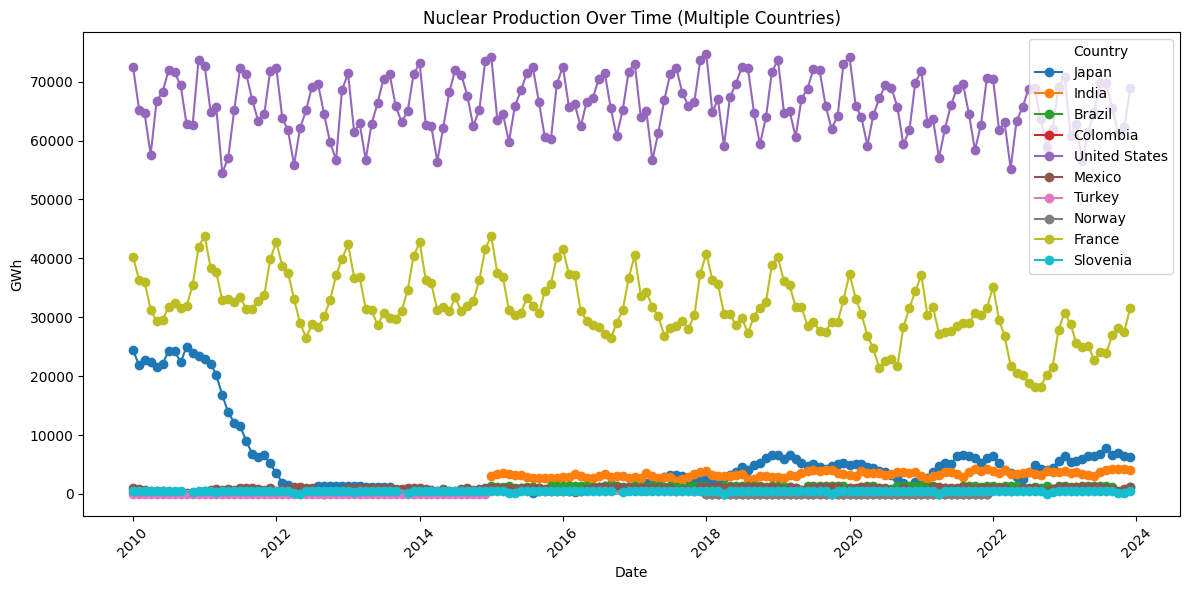

In [41]:
plot_country_data(filtered_df, train_countries, "Nuclear")

After visualising this plot in particular, I have been reminded that not all countries may be producing energy of a specific type so I may need to rescope the approach of my countries and products.

In [42]:
## Written with the assitance of ChatGPT to check if a country has production data for a specific product.
def check_zero_products(df, selected_products):
    """
    Checks which countries have all zeros for any of the selected products.
    Args:
        df (pd.DataFrame): Long-format dataframe with 'country_name', 'product', 'value'.
        selected_products (list): List of products to check.

    Returns:
        pd.DataFrame: A summary table showing True if the product is entirely zero for that country.
    """
    zero_check = (
        df[df["product"].isin(selected_products)]
        .groupby(["country_name", "product"])["value"]
        .apply(lambda x: (x == 0).all())
        .unstack(fill_value=False)
    )

    return zero_check

In [43]:
check_zero_products(filtered_df, selected_products=selected_products)

product,Geothermal,Hydro,Natural Gas,Nuclear,Solar,Wind
country_name,,,,,,
Argentina,True,False,False,False,False,False
Australia,False,False,False,True,False,False
Austria,False,False,False,True,False,False
Belgium,True,False,False,False,False,False
Brazil,True,False,False,False,False,False
Bulgaria,True,False,False,False,False,False
Canada,True,False,False,False,False,False
Chile,False,False,False,True,False,False
China,False,False,False,False,False,False


Many countries do not produce geothermal energy so I will remove it from our selected products. Nuclear is also inconsistent across our dataset and I will remove it from our features.

Let's redefine our values and refilter our dataset with this in mind.

In [44]:
selected_parameter = "Net Electricity Production"
selected_products = ["Natural Gas", "Hydro", "Wind", "Solar"]

In [45]:
filtered_df = dataframe[
    (dataframe["parameter"] == selected_parameter) &
    (dataframe["product"].isin(selected_products))
].copy()
filtered_df = filtered_df.drop("unit", axis=1, errors="ignore")
filtered_df["date"] = pd.to_datetime(filtered_df["date"])

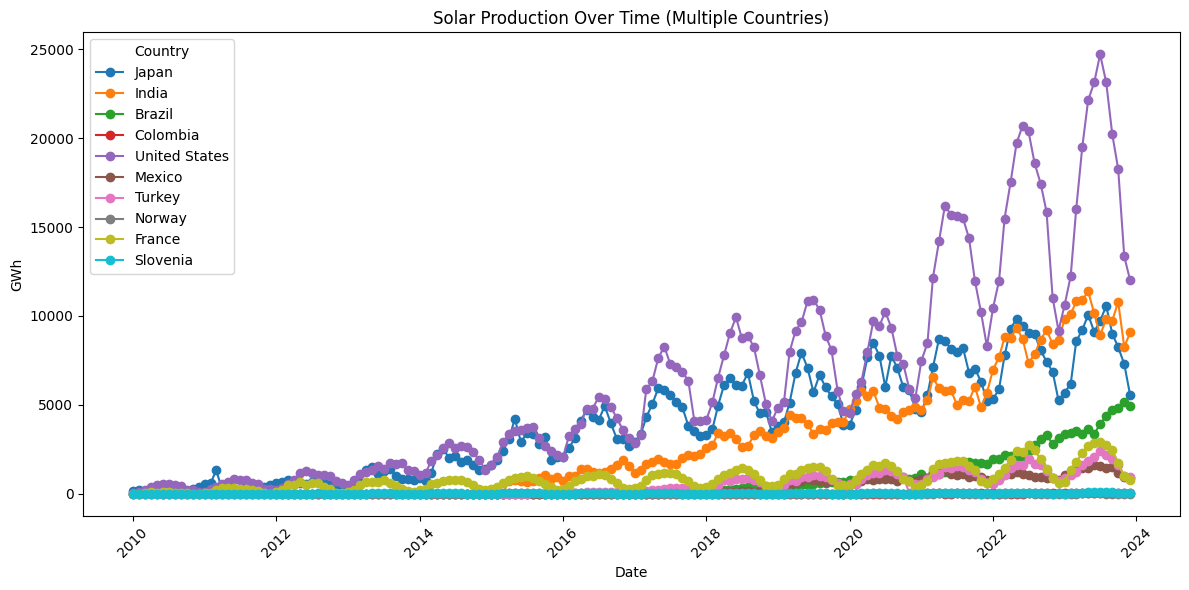

In [46]:
plot_country_data(filtered_df, train_countries, "Solar")

With that issue addressed, we want to reshape our dataframe to prepare it for sequencing.

In [47]:
pivoted_df = filtered_df.pivot_table(
    index=["country_name", "date"],
    columns="product",
    values="value"
).reset_index()
pivoted_df.fillna(0, inplace=True)

pivoted_df.head()

product,country_name,date,Hydro,Natural Gas,Solar,Wind
0,Argentina,2015-01-01,2519.945,6767.060,1.511,51.294
1,Argentina,2015-02-01,2032.279,6673.424,1.262,42.504
2,Argentina,2015-03-01,2142.899,7363.379,1.313,41.142
3,Argentina,2015-04-01,1890.171,6962.605,1.192,44.253
4,Argentina,2015-05-01,1827.250,7112.067,1.123,47.972


We performed a pivot on our select products to move them to the x axis of our dataframe and aggregate our countries, there appears to now be one list of feature values per country per date value which is ideal for when we eventually sequence our data into the RNN.
I'm going to filter once again to create a dataframe for our test and train countries.

In [48]:
train_df = pivoted_df[pivoted_df["country_name"].isin(train_countries)].copy()
test_df = pivoted_df[pivoted_df["country_name"].isin(test_countries)].copy()

We can check that the pivot kept all of our countries and series intact.

In [49]:
print(train_df["country_name"].unique())
print(train_df["country_name"].value_counts()) 

['Brazil' 'Colombia' 'France' 'India' 'Japan' 'Mexico' 'Norway' 'Slovenia'
 'Turkey' 'United States']
country_name
Japan            168
France           168
Turkey           168
Slovenia         168
Mexico           168
Norway           168
United States    168
Colombia         120
Brazil           108
India            108
Name: count, dtype: int64


Since we are going to make predictions later on unseen data we need a catch all scaling method, we can't really make scales 

In [50]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df[selected_products])

train_df[selected_products] = scaler.transform(train_df[selected_products])
test_df[selected_products] = scaler.transform(test_df[selected_products])

train_df.head()

product,country_name,date,Hydro,Natural Gas,Solar,Wind
612,Brazil,2015-01-01,0.815273,0.032527,0.000106,0.033330
613,Brazil,2015-02-01,0.713986,0.030812,0.000100,0.025115
614,Brazil,2015-03-01,0.768039,0.035370,0.000128,0.024091
615,Brazil,2015-04-01,0.701708,0.032737,0.000131,0.021465
616,Brazil,2015-05-01,0.680023,0.033232,0.000109,0.033959


In [ ]:
import numpy as np
## This function is written with the help of ChatGPT to create sequences for LSTM input.

def create_sequences(df, sequence_length, feature_cols, target_col):
    """
    Creates input sequences (X) and target values (y) for single-step prediction.

    Args:
        df (pd.DataFrame): Pivoted dataframe with 'country_name', 'date', and product columns.
        sequence_length (int): Number of time steps in the input sequence.
        feature_cols (list): List of feature column names to use as input features.
        target_col (str): Name of the target column to predict (e.g., "Natural Gas").

    Returns:
        X (np.array): Shape (num_sequences, sequence_length, num_features).
        y (np.array): Shape (num_sequences,) — to align with Dense(1) output.
    """
    X, y = [], []

    # Group data by country
    grouped = df.groupby("country_name")

    for country_name, group in grouped:
        # Sort by date within each country and reset index
        group = group.sort_values("date").reset_index(drop=True)

        # Extract features and targets
        features = group[feature_cols].values
        targets = group[target_col].values

        # Generate sequences
        for i in range(len(group) - sequence_length):
            X.append(features[i:i + sequence_length])
            y.append(targets[i + sequence_length])

    # Convert to numpy arrays
    return np.array(X), np.array(y)


Before we sequence we need to split our train df properly to get a train / val split. We want to use the front 80% of dates as training and our later 20% dates as validation. We are going to loop through each country to ensure that 

In [ ]:
train_split_list = []
val_split_list = []


for country in train_df["country_name"].unique():
    group = train_df[train_df["country_name"] == country].sort_values("date")
    split_index = int(0.8 * len(group))
    train_split_list.append(group.iloc[:split_index])
    val_split_list.append(group.iloc[split_index:])

train_df_split = pd.concat(train_split_list).reset_index(drop=True)
val_df_split = pd.concat(val_split_list).reset_index(drop=True)

print("Train set shape:", train_df_split.shape)
print("Validation set shape:", val_df_split.shape)

val_df_split.head()


Train set shape: (1206, 6)
Validation set shape: (306, 6)


product,country_name,date,Hydro,Natural Gas,Solar,Wind
0,Brazil,2022-03-01,0.993405,0.019023,0.087507,0.115962
1,Brazil,2022-04-01,0.904837,0.009472,0.085761,0.109762
2,Brazil,2022-05-01,0.851219,0.009020,0.083044,0.127659
3,Brazil,2022-06-01,0.796323,0.014074,0.082850,0.129440
4,Brazil,2022-07-01,0.777925,0.012299,0.097015,0.182892


Here I prepared our data using the sequence generation function from ChatGPT and the separate dataframes I created earlier. Using the above visualisations I noticed that the GWh trends follow a 4 monthly cycle that appears to represent seasonal changes. This would make a lot of sense typically when considering how electricity production needs would change when accounting for climate. Despite this we also want to capture more broader trends, i.e advancements in technology. In order to ideally capture the trends in the dataset I will start with a sequence length of 6 and potentially we can tweak this number later.

In [53]:
sequence_length = 6
feature_cols = selected_products

x_train, y_train = create_sequences(
    train_df_split, 
    sequence_length=sequence_length,
    feature_cols=feature_cols,
    target_col="Natural Gas"
)

x_val, y_val = create_sequences(
    val_df_split, 
    sequence_length=sequence_length,
    feature_cols=feature_cols,
    target_col="Natural Gas"
    )


Now we want to prepare our datasets and batch sizes. Since we are focussing on LTSM and GRU for sequence models and are dealing with a small number of simple features we can utilise a smaller batch size of 16.

Post inference update: I ended up testing a variety of batch sizes and error curves fluctuated much less with lower and lower batch sizes. I ended up settling with a batch size of 4 and that seemed ideal for both GRU and LTSM model.

In [54]:
import tensorflow as tf
batch_size = 4
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
#test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

I utilised code from COSC551 to confirm that our datasets have the right shape. They should all have sample shape `(batch_size, sequence_length, n_features)` and target shape `(batch_size,)`.

In [55]:
# Code implemented from COSC551 Lecture 7
s, t = next(iter(train_dataset))
print(f"Training: samples shape: {s.shape}, targets shape: {t.shape}")
s, t = next(iter(validation_dataset))
print(f"Validation: samples shape: {s.shape}, targets shape: {t.shape}")
##s, t = next(iter(test_dataset))
##print(f"Testing: samples shape: {s.shape}, targets shape: {t.shape}")

Training: samples shape: (4, 6, 4), targets shape: (4,)
Validation: samples shape: (4, 6, 4), targets shape: (4,)


To solve this problem I started by implementing a single layer LSTM on 32 units. Since the dataset is rather small and the feature size is small, having only 32 units made sense.
After some testing I lowered the recurrent dropout to 0.25 from 0.5.

In [56]:
from keras import layers, models, callbacks

input_shape = (sequence_length, len(selected_products))
inputs = layers.Input(shape=input_shape)
x = layers.LSTM(16, recurrent_dropout=0.5)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
LSTM1 = models.Model(inputs=inputs, outputs=outputs)

callbacks = [
    callbacks.EarlyStopping(monitor="val_loss",patience=3),
    callbacks.ModelCheckpoint(filepath="lstm1.keras",monitor="val_loss",save_best_only=True,),
    callbacks.TensorBoard(log_dir="log_dir_LSTM1",)]

LSTM1.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [57]:
LSTM1 = LSTM1.fit(train_dataset, validation_data=validation_dataset, epochs=20, callbacks=callbacks)

Epoch 1/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0053 - mae: 0.0436 - val_loss: 0.0307 - val_mae: 0.1633
Epoch 2/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - mae: 0.0660 - val_loss: 0.0144 - val_mae: 0.1102
Epoch 3/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0045 - mae: 0.0414 - val_loss: 0.0062 - val_mae: 0.0625
Epoch 4/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0022 - mae: 0.0290 - val_loss: 0.0072 - val_mae: 0.0743
Epoch 5/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0024 - mae: 0.0298 - val_loss: 0.0066 - val_mae: 0.0723
Epoch 6/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0020 - mae: 0.0281 - val_loss: 0.0049 - val_mae: 0.0598
Epoch 7/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0015 - mae: 0.0236 - val_loss: 0.0045 - val_mae: 0.0570
Epoch 8/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013 - mae: 0.0230 - val_loss: 0.0041 - val_mae: 0.0530
Epoch 9/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

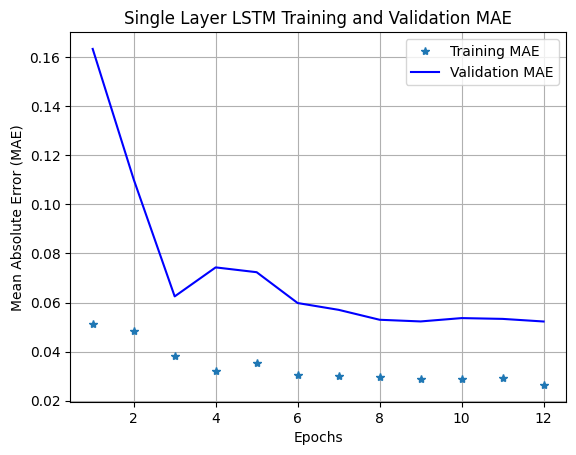

In [58]:
loss = LSTM1.history["mae"]
val_loss = LSTM1.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.grid(True)
plt.plot(epochs, loss, "*", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Single Layer LSTM Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.show()

Looking at the plot we see that the model stops generalising after the 6th epoch where afterwards there appears to plateau. MAE got as low as 0.04 in this instance.

In [59]:
from keras import layers, models, callbacks  
inputs = layers.Input(shape=input_shape)
x = layers.GRU(32, recurrent_dropout=0.2, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.2)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1)(x)
GRU1 = models.Model(inputs, outputs)

callbacks = [
    callbacks.EarlyStopping(monitor="val_loss", patience=3),
    callbacks.ModelCheckpoint(filepath="gru1.keras", monitor="val_loss", save_best_only=True),
    callbacks.TensorBoard(log_dir="log_dir_GRU1")
]

GRU1.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])


In [60]:
GRU1 = GRU1.fit(train_dataset, validation_data=validation_dataset, epochs=20, callbacks=callbacks)

Epoch 1/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0016 - mae: 0.0248 - val_loss: 0.0616 - val_mae: 0.2278
Epoch 2/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0088 - mae: 0.0449 - val_loss: 0.0254 - val_mae: 0.1418
Epoch 3/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0039 - mae: 0.0315 - val_loss: 0.0171 - val_mae: 0.1142
Epoch 4/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022 - mae: 0.0256 - val_loss: 0.0162 - val_mae: 0.1122
Epoch 5/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0025 - mae: 0.0265 - val_loss: 0.0150 - val_mae: 0.1091
Epoch 6/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018 - mae: 0.0224 - val_loss: 0.0114 - val_mae: 0.0938
Epoch 7/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - mae: 0.0210 - val_loss: 0.0093 - val_mae: 0.0820
Epoch 8/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mae: 0.0212 - val_loss: 0.0078 - val_mae: 0.0740
Epoch 9/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

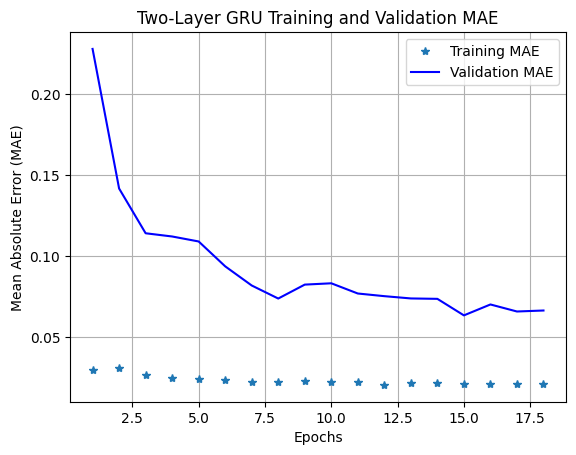

In [61]:
loss = GRU1.history["mae"]
val_loss = GRU1.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.grid(True)
plt.plot(epochs, loss, "*", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Two-Layer GRU Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.show()

A few issues to address with this result.
It should be noted that training error is low and plateaus almost immediately with almost no 
Interestingly, the validation MAE for this GRU model shows unusual fluctuations after the early epochs, indicating potential overfitting. I assume that perhaps 2 by 32 layers is creating too many unimportant representations of the training data. The best validation MAE was observed around epoch 8, however we should take this result with a grain of salt.


I am going to try and recompile this model with less units to see if this improves learning.

In [62]:
from keras import layers, models, callbacks  
inputs = layers.Input(shape=input_shape)
x = layers.GRU(16, recurrent_dropout=0.3, return_sequences=True)(inputs)
x = layers.GRU(16, recurrent_dropout=0.3)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
GRU2 = models.Model(inputs, outputs)

callbacks = [
    callbacks.EarlyStopping(monitor="val_loss", patience=3),
    callbacks.ModelCheckpoint(filepath="gru2.keras", monitor="val_loss", save_best_only=True),
    callbacks.TensorBoard(log_dir="log_dir_GRU2")
]

GRU2.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [63]:
GRU2 = GRU2.fit(train_dataset, validation_data=validation_dataset, epochs=20, callbacks=callbacks)

Epoch 1/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0029 - mae: 0.0337 - val_loss: 0.0460 - val_mae: 0.2010
Epoch 2/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0085 - mae: 0.0516 - val_loss: 0.0182 - val_mae: 0.1231
Epoch 3/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0031 - mae: 0.0322 - val_loss: 0.0179 - val_mae: 0.1235
Epoch 4/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0029 - mae: 0.0313 - val_loss: 0.0110 - val_mae: 0.0932
Epoch 5/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018 - mae: 0.0264 - val_loss: 0.0096 - val_mae: 0.0833
Epoch 6/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - mae: 0.0238 - val_loss: 0.0130 - val_mae: 0.1058
Epoch 7/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021 - mae: 0.0271 - val_loss: 0.0079 - val_mae: 0.0766
Epoch 8/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mae: 0.0235 - val_loss: 0.0076 - val_mae: 0.0728
Epoch 9/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

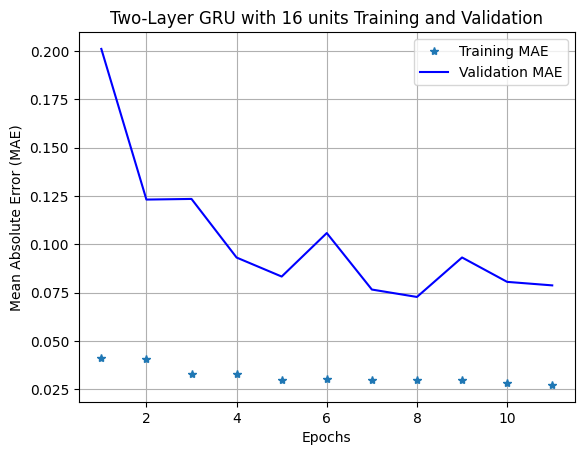

In [64]:
loss = GRU2.history["mae"]
val_loss = GRU2.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.grid(True)
plt.plot(epochs, loss, "*", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Two-Layer GRU with 16 units " \
"Training and Validation")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.show()

In this model with 16 GRU units, the training error drops down nice and steady, but the validation error tells a bit of a different story. While the validation MAE improves at first, it bounces around quite a bit after about 6–7 epochs and never really settles close to the training curve. 
While it does appear to improve slightly from our previous model I'm going to attempt to fit a one layer GRU and compare it to the LTSM.

In [65]:
from keras import layers, models, callbacks  
inputs = layers.Input(shape=input_shape)
x = layers.GRU(16, recurrent_dropout=0.3, return_sequences=True)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
GRU3 = models.Model(inputs, outputs)

callbacks = [
    callbacks.EarlyStopping(monitor="val_loss", patience=3),
    callbacks.ModelCheckpoint(filepath="gru3.keras", monitor="val_loss", save_best_only=True),
    callbacks.TensorBoard(log_dir="log_dir_GRU3")
]

GRU3.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [66]:
GRU3 = GRU3.fit(train_dataset, validation_data=validation_dataset, epochs=20, callbacks=callbacks)

Epoch 1/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0045 - mae: 0.0401 - val_loss: 0.0343 - val_mae: 0.1653
Epoch 2/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0096 - mae: 0.0586 - val_loss: 0.0191 - val_mae: 0.1165
Epoch 3/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0045 - mae: 0.0410 - val_loss: 0.0145 - val_mae: 0.0977
Epoch 4/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - mae: 0.0356 - val_loss: 0.0137 - val_mae: 0.0954
Epoch 5/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026 - mae: 0.0320 - val_loss: 0.0108 - val_mae: 0.0788
Epoch 6/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0020 - mae: 0.0285 - val_loss: 0.0125 - val_mae: 0.0909
Epoch 7/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0022 - mae: 0.0295 - val_loss: 0.0103 - val_mae: 0.0768
Epoch 8/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0017 - mae: 0.0262 - val_loss: 0.0119 - val_mae: 0.0877
Epoch 9/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

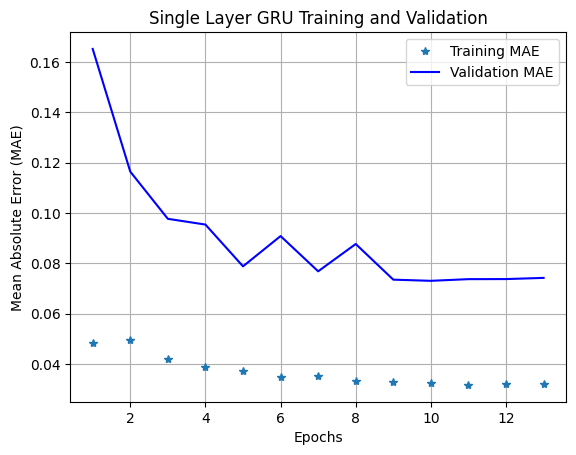

In [67]:
loss = GRU3.history["mae"]
val_loss = GRU3.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.grid(True)
plt.plot(epochs, loss, "*", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Single Layer GRU " \
"Training and Validation")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.show()

Frustratingly, none of the GRU models provided evidence that they could perform the task of predicting natural gas output better than the our first LTSM model. 

In all of my models I am struggling to understand why the training error plateaus so quickly. It may be the nature of the way I implemented the solution to this problem - not enough diversity in features or perhaps an oversight in the selection of my countries. I could have considered delving deeper into the data across the countries.

Regardless, we must carry on and utilised our chosen model (single layer LSTM) and apply it to the unseen country data.

In [ ]:
best_model = models.load_model("lstm1.keras")

I chose an arbitrary year (2021) to provide a snapshot window for our predictions.
We trim our test dataset to fit this window and then create sequence data to pass to the model.

In [69]:
start_2021 = "2021-01-01"
end_2021 = "2021-12-31"
year_2021_test_df = test_df[test_df["date"].between(start_2021, end_2021)].copy()
year_2021_test_df.head()

product,country_name,date,Hydro,Natural Gas,Solar,Wind
240,Australia,2021-01-01,0.023941,0.018654,0.131576,0.048928
241,Australia,2021-02-01,0.022676,0.016663,0.112406,0.042093
242,Australia,2021-03-01,0.028739,0.018493,0.106923,0.044093
243,Australia,2021-04-01,0.030745,0.017919,0.092846,0.035649
244,Australia,2021-05-01,0.035348,0.020045,0.077976,0.045364


In [70]:
x_test, y_test = create_sequences(year_2021_test_df, 
                                  sequence_length=sequence_length, 
                                  feature_cols=feature_cols,
                                  target_col="Natural Gas")

print(x_test.shape, y_test.shape)

(30, 6, 4) (30,)


In [71]:
predictions = best_model.predict(x_test)
print(predictions.shape)
print(y_test.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
(30, 1)
(30,)


Since the intial scaler was fit on all 4 selected_products I decided to recreate the shape of the initial input using dummy variables that are simply an array of zeroes in order to apply the inverse_transform function to get the true GWh from our model.

In [ ]:
num_samples = predictions.shape[0]

dummy_pred = np.zeros((num_samples, len(selected_products)))
dummy_true = np.zeros((num_samples, len(selected_products)))


idx = selected_products.index("Natural Gas")

dummy_pred[:, idx] = predictions.flatten()
dummy_true[:, idx] = y_test.flatten()


dummy_pred_inverse = scaler.inverse_transform(dummy_pred)
dummy_true_inverse = scaler.inverse_transform(dummy_true)

predictions_original = dummy_pred_inverse[:, idx]
y_test_original = dummy_true_inverse[:, idx]


[ 4351.1     3825.7274  3225.9545  3226.1624  3137.7105  3382.2842
  1391.6846  1632.1737  1198.2558  1204.096   1047.6441  1170.4893
 12442.0234 10218.1106 12533.1961 11776.6141 14510.895  14131.0005
 16665.9793 14691.8146 13420.8805 13854.642  14046.3227 15311.8402
   110.7403    59.5524   167.0739    50.5675    17.7341    73.4753]


In [74]:
print(y_test_original)
print(predictions_original)

[ 4351.1     3825.7274  3225.9545  3226.1624  3137.7105  3382.2842
  1391.6846  1632.1737  1198.2558  1204.096   1047.6441  1170.4893
 12442.0234 10218.1106 12533.1961 11776.6141 14510.895  14131.0005
 16665.9793 14691.8146 13420.8805 13854.642  14046.3227 15311.8402
   110.7403    59.5524   167.0739    50.5675    17.7341    73.4753]
[13179.12989365 13140.38430023 13230.05653824 13302.76646033
 13515.15488627 13591.25080243  9791.74129114  9797.18784565
  9880.1807215   9907.76635488  9985.26636325 10054.88581225
 18445.70036057 18949.22399587 19000.9607502  19137.08859157
 19036.90256998 19353.92159417 20518.18308342 20772.74867471
 20688.24143763 20222.40922392 20074.16355229 19960.14391447
  8057.59847523  8057.80504586  8046.02316854  8057.25737639
  8046.55907599  8031.92417154]


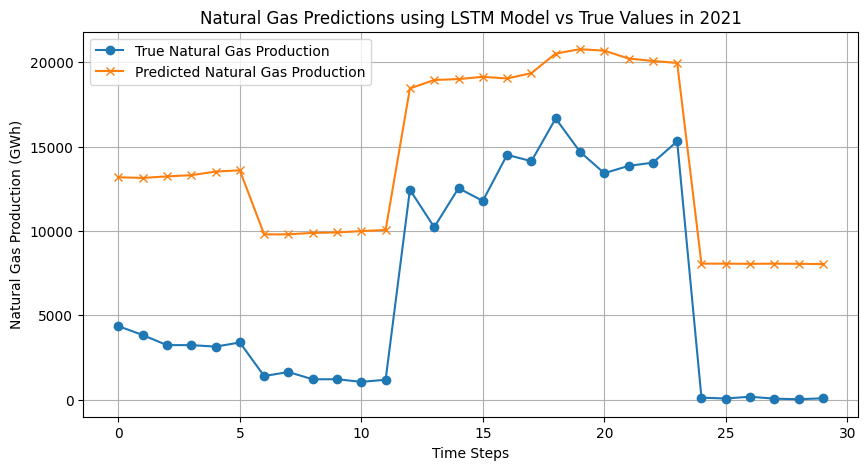

In [79]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_original, label="True Natural Gas Production", marker='o')
plt.plot(predictions_original, label="Predicted Natural Gas Production", marker='x')
plt.title("Natural Gas Predictions using LSTM Model vs True Values in 2021")
plt.xlabel("Time Steps")
plt.ylabel("Natural Gas Production (GWh)")
plt.legend()
plt.grid(True)
plt.show()

Our LSTM model was able to capture the general seasonal structure of Natural Gas production but consistently overestimated the GWh output. This confirms that while the model learned broad patterns during training but unable to accurately predict. The way that I set up the sequence data causes the model to lack alot of geography, population or GDP related context. Adding information about a countries population and relative GDP could let the model learn important real life relationships that impact it's energy output. We can say that the model learns consistent historic and time dependent trends but fails to understand niche contextual ideas about countries which would cause it to perform poorly to unseen data.